['EURUSD=X', 'GBPUSD=X', 'AUDUSD=X']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for EURUSD=X saved to SAR5\EURUSD=X_adjusted_close_data.csv
Data for GBPUSD=X saved to SAR5\GBPUSD=X_adjusted_close_data.csv
Data for AUDUSD=X saved to SAR5\AUDUSD=X_adjusted_close_data.csv


All pairs tested for cointegration and their ADF test results:
{'pair': ('AUDUSD=X', 'EURUSD=X'), 'hedge_ratio': 0.5466338336142337, 'adf_statistic': -1.928127961775449, 'p_value': 0.31894669746104626, 'critical_values': {'1%': -3.4387614757350087, '5%': -2.865252556432172, '10%': -2.5687469247205788}, 'is_cointegrated': False}
{'pair': ('AUDUSD=X', 'GBPUSD=X'), 'hedge_ratio': 0.45734891598044336, 'adf_statistic': -1.9426935634574067, 'p_value': 0.31225076867738255, 'critical_values': {'1%': -3.438783171038672, '5%': -2.865262118650577, '10%': -2.568752018688748}, 'is_cointegrated': False}
{'pair': ('EURUSD=X', 'GBPUSD=X'), 'hedge_ratio': 0.7835826753482578, 'adf_statistic': -3.758951743986156, 'p_value': 0.0033563477726134693, 'critical_values': {'1%': -3.4388159246521433, '5%': -2.865276554696385, '10%': -2.5687597090530696}, 'is_cointegrated': True}

Cointegrated pairs:
('EURUSD=X', 'GBPUSD=X')


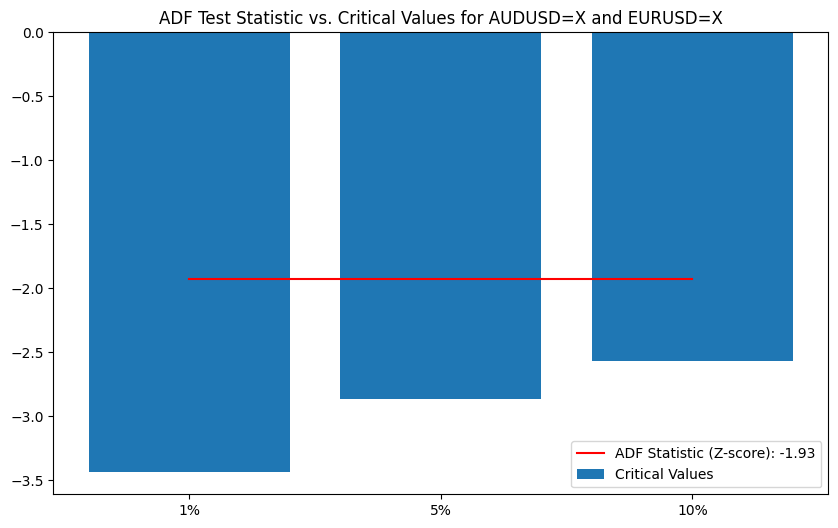

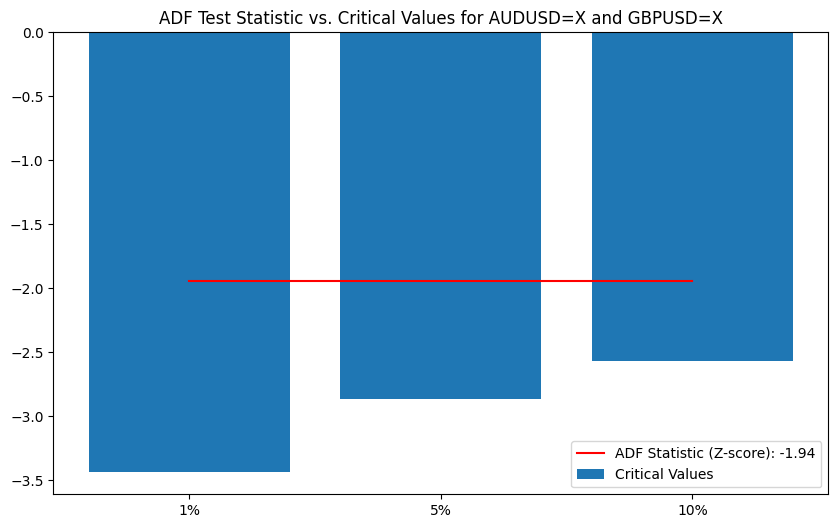

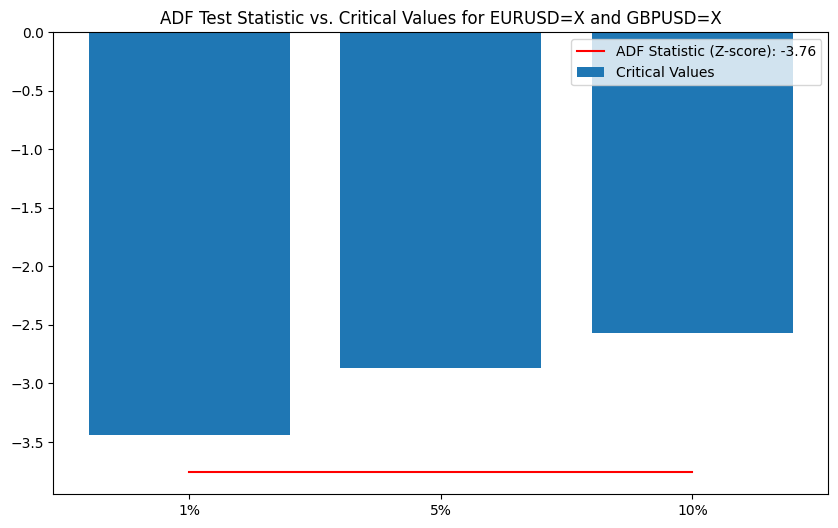

In [2]:
import os
import pandas as pd
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn

# Define the tickers
tickers = [
    'EURUSD=X', 'GBPUSD=X', 'AUDUSD=X'] 

print(tickers)



# Set the start and end dates for data download
start_date = '2021-01-01'
end_date = '2023-12-31'

# Create a directory to store the CSV files, if it doesn't exist
folder_name = 'SAR5'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Download and save historical data for each ticker
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    data.dropna(inplace=True)
    file_path = os.path.join(folder_name, f'{ticker}_adjusted_close_data.csv')
    data.to_csv(file_path)
    print(f'Data for {ticker} saved to {file_path}')

# Load the downloaded data into pandas DataFrames
dataframes = {}
csv_files = [f for f in os.listdir(folder_name) if f.endswith('.csv')]
for file in csv_files:
    ticker = file.replace('_adjusted_close_data.csv', '')
    df = pd.read_csv(os.path.join(folder_name, file), index_col='Date', parse_dates=True)
    dataframes[ticker] = df['Adj Close']
trades_df = pd.DataFrame(columns=[
    'Date', 'Pair', 'Trade_Type', 'Quantity_Stock1', 'Entry_Price_Stock1', 'Exit_Price_Stock1',
    'Quantity_Stock2', 'Entry_Price_Stock2', 'Exit_Price_Stock2', 'Spread', 'Hedge_Ratio'
])
print(trades_df)   
def get_current_price(ticker):
    """
    Fetches the most recent price for a given ticker from the historical data saved in CSV files.
    
    :param ticker: The ticker symbol for which to fetch the current price.
    :return: The most recent price as a float.
    """
    # Assuming the folder structure and file naming convention as defined earlier
    file_path = os.path.join('SAR3', f'{ticker}_adjusted_close_data.csv')
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Data file for {ticker} does not exist.")
        return None
    
    # Load the most recent data from the CSV file
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    
    # Fetch the last available price
    current_price = df['Adj Close'].iloc[-1]
    
    return current_price

# Identify all unique pairs of assets for cointegration testing
pairs = combinations(dataframes.keys(), 2)

# Perform cointegration tests on each pair
cointegration_results = []
for stock1, stock2 in pairs:
    merged_df = pd.merge(dataframes[stock1], dataframes[stock2], left_index=True, right_index=True, suffixes=('_x', '_y'))
    merged_df.dropna
# Continue from the cointegration test setup...

for stock1, stock2 in combinations(dataframes.keys(), 2):
    merged_df = pd.merge(dataframes[stock1], dataframes[stock2], left_index=True, right_index=True, suffixes=('_x', '_y'))
    merged_df.dropna(inplace=True)

    if len(merged_df) < 20:  # Ensure there's enough data
        continue

    # OLS regression to find the hedge ratio
    X = sm.add_constant(merged_df.iloc[:, 1])
    model = sm.OLS(merged_df.iloc[:, 0], X).fit()
    hedge_ratio = model.params.iloc[1]

    # Calculate the spread
    spread = merged_df.iloc[:, 0] - hedge_ratio * merged_df.iloc[:, 1]
    
    # Perform the ADF test on the spread
    adf_result = adfuller(spread)
    
    # Store results
    cointegration_results.append({
        'pair': (stock1, stock2),
        'hedge_ratio': hedge_ratio,
        'adf_statistic': adf_result[0],
        'p_value': adf_result[1],
        'critical_values': adf_result[4],
        'is_cointegrated': adf_result[1] < 0.05  # Using a 5% significance level
    })
# Print all pairs tested for cointegration along with their ADF test results
print("All pairs tested for cointegration and their ADF test results:")
for result in cointegration_results:
    print(result)
    
# Filter pairs that are cointegrated
cointegrated_pairs = [result for result in cointegration_results if result['is_cointegrated']]

# Print cointegrated pairs
print("\nCointegrated pairs:")
for pair in cointegrated_pairs:
    print(pair['pair'])

# Function to prepare data for LSTM model
def prepare_data(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback - 1):
        X.append(data[i:(i + lookback)])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

for result in cointegration_results:
    pair = result['pair']
    adf_statistic = result['adf_statistic']
    critical_values = result['critical_values']

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(critical_values)), list(critical_values.values()), label='Critical Values')
    plt.plot([0, 1, 2], [adf_statistic, adf_statistic, adf_statistic], label=f'ADF Statistic (Z-score): {adf_statistic:.2f}', color='r')
    plt.xticks(range(len(critical_values)), labels=critical_values.keys())
    plt.title(f'ADF Test Statistic vs. Critical Values for {pair[0]} and {pair[1]}')
    plt.legend()
    plt.show()
    

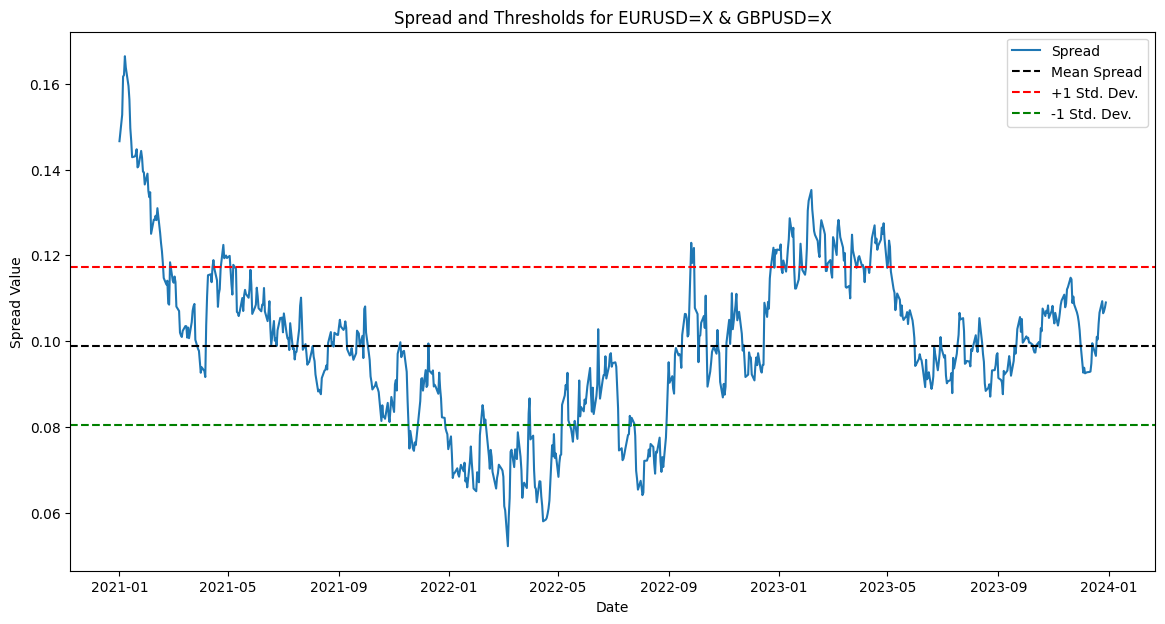

In [3]:
for result in cointegrated_pairs:
    stock1, stock2 = result['pair']
    hedge_ratio = result['hedge_ratio']
    
    # Load and prepare the spread data again if not already available in 'result'
    merged_df = pd.merge(dataframes[stock1], dataframes[stock2], left_index=True, right_index=True, suffixes=('_x', '_y'))
    spread = merged_df.iloc[:, 0] - hedge_ratio * merged_df.iloc[:, 1]
    
    # Calculate mean and standard deviation of the spread
    mean_spread = np.mean(spread)
    std_spread = np.std(spread)
    
    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(spread.index, spread, label='Spread')
    plt.axhline(mean_spread, color='black', linestyle='--', label='Mean Spread')
    plt.axhline(mean_spread + std_spread, color='red', linestyle='--', label='+1 Std. Dev.')
    plt.axhline(mean_spread - std_spread, color='green', linestyle='--', label='-1 Std. Dev.')
    
    plt.title(f'Spread and Thresholds for {stock1} & {stock2}')
    plt.xlabel('Date')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM Model Results:
                   pair  train_rmse  test_rmse
0  (EURUSD=X, GBPUSD=X)    0.006262   0.004671


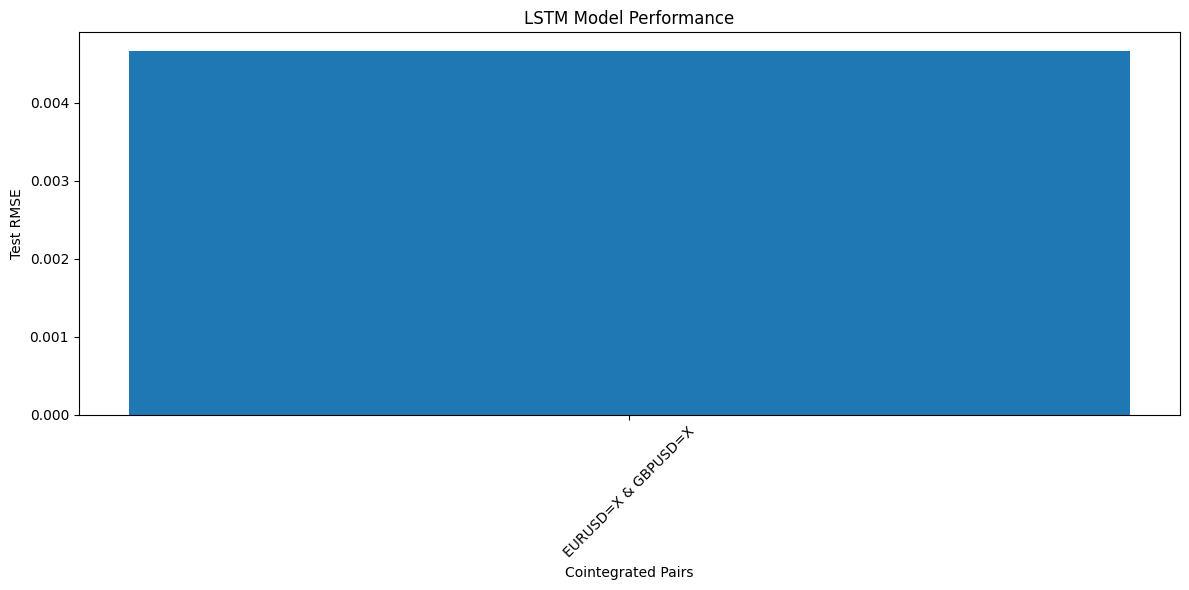

In [4]:
# Example of dynamically creating cointegrated_pairs based on some cointegration criteria
cointegrated_pairs = [
    {'pair': result['pair'], 'hedge_ratio': result['hedge_ratio']}
    for result in cointegration_results if result['is_cointegrated']
]

# LSTM model training for each cointegrated pair
lstm_results = []
for result in cointegrated_pairs:
    stock1, stock2 = result['pair']
    
    # Load and prepare the spread data
    merged_df = pd.merge(dataframes[stock1], dataframes[stock2], left_index=True, right_index=True, suffixes=('_x', '_y'))
    spread = merged_df.iloc[:, 0] - result['hedge_ratio'] * merged_df.iloc[:, 1]

    # Apply MinMaxScaler to the spread
    scaler = MinMaxScaler(feature_range=(0, 1))
    spread_scaled = scaler.fit_transform(spread.values.reshape(-1, 1))

    # Assuming you have defined lookback and embargo_period
    lookback = 60
    embargo_period = 5  # Number of days to leave out after the training set
    purge_period = 5

    # Now that spread_scaled is defined, calculate the index to start the test set, considering the embargo period
    test_start_index = int(len(spread_scaled) * 0.8) + embargo_period

    # Prepare data with lookback
    X, y = prepare_data(spread_scaled, lookback)

    # Calculate indices for training and test splits with purging and embargo adjustments
    total_size = len(X)
    train_size = int(total_size * 0.8)  # 80% for training
    purge_index = train_size - purge_period
    embargo_index = train_size + embargo_period

    # Split data into training and test sets considering purging and embargo
    X_train, X_test = X[:purge_index], X[embargo_index:]
    y_train, y_test = y[:purge_index], y[embargo_index:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Define and fit the LSTM model
    model = Sequential()
    model.add(Input(shape=(lookback, 1)))  # Specify input shape here
    model.add(LSTM(30))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0, validation_data=(X_test, y_test))
    
    # Evaluate the model
    train_predict = scaler.inverse_transform(model.predict(X_train))
    test_predict = scaler.inverse_transform(model.predict(X_test))
    
    train_rmse = np.sqrt(np.mean((scaler.inverse_transform(y_train.reshape(-1, 1)) - train_predict)**2))
    test_rmse = np.sqrt(np.mean((scaler.inverse_transform(y_test.reshape(-1, 1)) - test_predict)**2))
    
    lstm_results.append({
        'pair': (stock1, stock2),
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })

# Display LSTM model results
lstm_results_df = pd.DataFrame(lstm_results)
print("LSTM Model Results:")
print(lstm_results_df.sort_values(by='test_rmse'))

# Visualize the LSTM model results
plt.figure(figsize=(12, 6))
plt.bar(range(len(lstm_results_df)), lstm_results_df['test_rmse'])
plt.xticks(range(len(lstm_results_df)), [f'{pair[0]} & {pair[1]}' for pair in lstm_results_df['pair']], rotation=45)
plt.xlabel('Cointegrated Pairs')
plt.ylabel('Test RMSE')
plt.title('LSTM Model Performance')
plt.tight_layout()
plt.show()


In [5]:
# Print the current price for each ticker
for ticker in tickers:
    current_price = get_current_price(ticker)
    if current_price is not None:
        print(f"The current price for {ticker} is: {current_price:.2f}")
    else:
        print(f"Failed to fetch the current price for {ticker}")
# Assuming stock1 and stock2 are defined and contain the keys for the data frames in the 'dataframes' dictionary
stock1_key = stock1  # 
stock2_key = stock2  # 

# Retrieve the data frames from the dictionary
df_stock1 = dataframes[stock1_key]
df_stock2 = dataframes[stock2_key]

# Print the data frames
print(f"Data Frame for {stock1_key}:")
print(df_stock1)
print("\n")  # Print a newline for better separation
print(f"Data Frame for {stock2_key}:")
print(df_stock2)


The current price for EURUSD=X is: 1.11
The current price for GBPUSD=X is: 1.27
The current price for AUDUSD=X is: 0.68
Data Frame for EURUSD=X:
Date
2021-01-01    1.218027
2021-01-04    1.225070
2021-01-05    1.225160
2021-01-06    1.230027
2021-01-07    1.234111
                ...   
2023-12-25    1.102657
2023-12-26    1.102026
2023-12-27    1.104301
2023-12-28    1.110864
2023-12-29    1.106819
Name: Adj Close, Length: 781, dtype: float64


Data Frame for GBPUSD=X:
Date
2021-01-01    1.367301
2021-01-04    1.368420
2021-01-05    1.357160
2021-01-06    1.362955
2021-01-07    1.362528
                ...   
2023-12-25    1.267700
2023-12-26    1.270487
2023-12-27    1.272718
2023-12-28    1.280082
2023-12-29    1.273399
Name: Adj Close, Length: 781, dtype: float64


In [6]:
# Assuming trades_df exists, if not, initialize it
trades_df = pd.DataFrame(columns=[
    'Date', 'Pair', 'Trade_Type', 'Quantity_Stock1', 'Entry_Price_Stock1', 'Exit_Price_Stock1',
    'Quantity_Stock2', 'Entry_Price_Stock2', 'Exit_Price_Stock2', 'Spread', 'Hedge_Ratio'
])
print(trades_df)

Empty DataFrame
Columns: [Date, Pair, Trade_Type, Quantity_Stock1, Entry_Price_Stock1, Exit_Price_Stock1, Quantity_Stock2, Entry_Price_Stock2, Exit_Price_Stock2, Spread, Hedge_Ratio]
Index: []


In [7]:
def run_backtest(entry_threshold, exit_threshold):
    """
    Simulate trading strategy with specified entry and exit thresholds,
    and return a performance metric (e.g., net profit).

    Parameters:
    - entry_threshold: The threshold for entering trades.
    - exit_threshold: The threshold for exiting trades.

    Returns:
    - performance_metric: A numeric value representing the strategy's performance with the given thresholds.
    """
    net_profit = 100  # Example performance metric

    for i in range(1, len(spread)):
        # Entry logic (simplified example)
        if spread.iloc[i-1] > mean_spread + entry_threshold and spread.iloc[i] <= mean_spread + entry_threshold:
            # Simulate entering trade
            entry_price = spread.iloc[i]
        
        # Exit logic (simplified example)
        elif spread.iloc[i-1] < mean_spread - exit_threshold and spread.iloc[i] >= mean_spread - exit_threshold:
            # Simulate exiting trade
            exit_price = spread.iloc[i]
            net_profit += exit_price - entry_price  # Calculate profit for this trade

    # Here, you would include more detailed trading logic,
    # including handling long/short positions, calculating profits/losses, etc.

    return net_profit  # Return net profit as performance metric

# Define your range of threshold values
entry_thresholds = np.arange(0.25, 2.5, 0.05)  # Example: 0.5 to 2.5 standard deviations, in steps of 0.1
exit_thresholds = np.arange(0.25, 2.5, 0.05)   # Similar range for exit thresholds

# Placeholder for best threshold values found
best_entry_threshold = None
best_exit_threshold = None
best_performance_metric = -np.inf  # Assuming higher is better, e.g., net profit

for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        # Run a backtest with these threshold values
        performance_metric = run_backtest(entry_threshold, exit_threshold)  # Define this function
        
        # Check if current iteration's performance is better than the best found so far
        if performance_metric > best_performance_metric:
            best_performance_metric = performance_metric
            best_entry_threshold = entry_threshold
            best_exit_threshold = exit_threshold

# Now, best_entry_threshold and best_exit_threshold hold the optimized values
print(f"Optimized Entry Threshold: {best_entry_threshold}, Optimized Exit Threshold: {best_exit_threshold}")



Optimized Entry Threshold: 0.25, Optimized Exit Threshold: 0.25


         Date       Trade    Spread
0  2021-02-26    Go Short  0.118387
1  2021-03-29  Exit Short  0.098161
2  2021-04-14    Go Short  0.117228
3  2021-07-08  Exit Short  0.097910
4  2021-11-17     Go Long  0.080188
5  2021-12-09   Exit Long  0.099443
6  2021-12-28     Go Long  0.079659
7  2022-06-15   Exit Long  0.102774
8  2022-07-08     Go Long  0.074487
9  2022-09-16   Exit Long  0.101421
10 2022-09-26    Go Short  0.122928
11 2022-10-04  Exit Short  0.095083
12 2022-12-26    Go Short  0.121779
13 2023-06-01  Exit Short  0.094198
{'Date': Timestamp('2021-02-26 00:00:00'), 'Trade': 'Go Short', 'Spread': 0.11838748169862146}
{'Date': Timestamp('2021-03-29 00:00:00'), 'Trade': 'Exit Short', 'Spread': 0.09816068935087574}
{'Date': Timestamp('2021-04-14 00:00:00'), 'Trade': 'Go Short', 'Spread': 0.11722804624139904}
{'Date': Timestamp('2021-07-08 00:00:00'), 'Trade': 'Exit Short', 'Spread': 0.09790967313950949}
{'Date': Timestamp('2021-11-17 00:00:00'), 'Trade': 'Go Long', 'Spread': 0.0

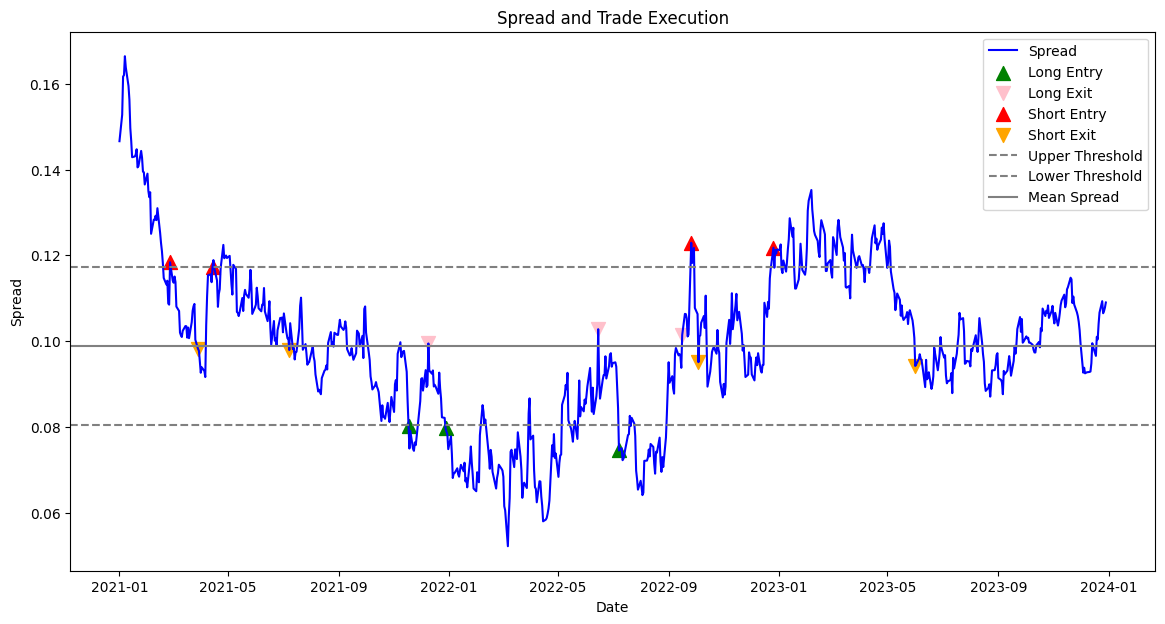

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize position tracking
current_position = None  # Possible values: None, 'Long', 'Short'


# Calculate the spread
spread = merged_df.iloc[:, 0] - hedge_ratio * merged_df.iloc[:, 1]
# Calculate mean and standard deviation of the spread
mean_spread = spread.mean()
std_spread = spread.std()

# Entry and exit thresholds
upper_threshold = mean_spread + std_spread
lower_threshold = mean_spread - std_spread

# Initialize a list to keep track of trades
trades = []

# Simulate the trading strategy
for i in range(1, len(spread)):
    # Go long (buy A, sell B)
    if spread.iloc[i-1] > lower_threshold and spread.iloc[i] <= lower_threshold and current_position is None:
        trades.append({'Date': spread.index[i], 'Trade': 'Go Long', 'Spread': spread.iloc[i]})
        current_position = 'Long'
        
    # Go short (sell A, buy B)
    elif spread.iloc[i-1] < upper_threshold and spread.iloc[i] >= upper_threshold and current_position is None:
        trades.append({'Date': spread.index[i], 'Trade': 'Go Short', 'Spread': spread.iloc[i]})
        current_position = 'Short'
        
    # Exit long position when spread reaches mean
    elif current_position == 'Long' and spread.iloc[i] >= mean_spread:
        trades.append({'Date': spread.index[i], 'Trade': 'Exit Long', 'Spread': spread.iloc[i]})
        current_position = None
        
    # Exit short position when spread reaches mean
    elif current_position == 'Short' and spread.iloc[i] <= mean_spread:
        trades.append({'Date': spread.index[i], 'Trade': 'Exit Short', 'Spread': spread.iloc[i]})
        current_position = None


# Convert trade log into DataFrame for easier viewing
trades_df = pd.DataFrame(trades)

print(trades_df)


# Example output of trades log
for trade in trades:
    print(trade)

import matplotlib.pyplot as plt

# Assuming 'spread' is a pandas Series with 'Date' as its index
# Plot the spread
plt.figure(figsize=(14, 7))  # Set figure size
plt.plot(spread.index, spread, label='Spread', color='blue')

# Highlight entry points for long positions in green
long_entries = trades_df[trades_df['Trade'] == 'Go Long']['Date']
plt.scatter(long_entries, spread.loc[long_entries], color='green', label='Long Entry', marker='^', s=100)

# Highlight exit points for long positions in black
long_exits = trades_df[trades_df['Trade'] == 'Exit Long']['Date']
plt.scatter(long_exits, spread.loc[long_exits], color='pink', label='Long Exit', marker='v', s=100)

# Highlight entry points for short positions in red
short_entries = trades_df[trades_df['Trade'] == 'Go Short']['Date']
plt.scatter(short_entries, spread.loc[short_entries], color='red', label='Short Entry', marker='^', s=100)

# Highlight exit points for short positions in orange
short_exits = trades_df[trades_df['Trade'] == 'Exit Short']['Date']
plt.scatter(short_exits, spread.loc[short_exits], color='orange', label='Short Exit', marker='v', s=100)

# Plot entry and exit thresholds
plt.axhline(upper_threshold, color='grey', linestyle='--', label='Upper Threshold')
plt.axhline(lower_threshold, color='grey', linestyle='--', label='Lower Threshold')
plt.axhline(mean_spread, color='grey', linestyle='-', label='Mean Spread')

plt.title('Spread and Trade Execution')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()

plt.show()



In [10]:
# Assuming 'spread' is your pandas Series with 'Date' as its index
# And 'trades_df' contains your trades log

# Calculate returns for each trade
trade_returns = []
for i in range(len(trades_df) - 1):
    current_trade = trades_df.iloc[i]
    next_trade = trades_df.iloc[i + 1]
    
    if current_trade['Trade'] in ['Go Long', 'Go Short']:
        # Calculate return
        entry_price = current_trade['Spread']
        exit_price = next_trade['Spread']
        trade_return = (exit_price - entry_price) / entry_price
        
        # Adjust sign based on trade type
        if current_trade['Trade'] == 'Go Short':
            trade_return = -trade_return
        
        trade_returns.append(trade_return)

# Convert trade returns to a pandas Series
trade_returns_series = pd.Series(trade_returns)

# Calculate total return
total_return = np.prod(1 + trade_returns_series) - 1

# Calculate maximum drawdown
cumulative_returns = (1 + trade_returns_series).cumprod()
drawdowns = cumulative_returns.div(cumulative_returns.cummax()) - 1
max_drawdown = drawdowns.min()

# Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
sharpe_ratio = np.sqrt(252) * trade_returns_series.mean() / trade_returns_series.std()

print(f"Total Return: {total_return*100:.2f}%")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Total Return: 346.94%
Max Drawdown: 0.00%
Sharpe Ratio: 55.68


In [22]:

def execute_trades_with_logic(pairs, lower_threshold, upper_threshold, mean_spread):
    global trades_df, current_position

    for pair in pairs:
        stock1, stock2 = pair['pair']
        hedge_ratio = pair['hedge_ratio']
        
        # Fetch current prices using the previously defined get_current_price function
        current_price_stock1 = get_current_price(stock1)
        current_price_stock2 = get_current_price(stock2)
        
        # Calculate the current spread
        current_spread = current_price_stock1 - hedge_ratio * current_price_stock2
        
        # Determine the position size (this could be dynamic based on your capital allocation strategy)
        position_size = 10000  # Example fixed position size
        
        # Calculate quantities based on the position size and hedge ratio
        quantity_stock1 = position_size / current_price_stock1
        quantity_stock2 = (position_size / current_price_stock2) * hedge_ratio
        
        # Check trading conditions
        if current_spread > upper_threshold and current_position is None:
            # Go long (buy stock1, sell stock2)
            trades_df = trades_df.append({
                'Date': pd.Timestamp.now(),
                'Pair': f'{stock1}/{stock2}',
                'Trade_Type': 'Go Long',
                'Quantity_Stock1': quantity_stock1,
                'Price_Stock1': current_price_stock1,
                'Quantity_Stock2': -quantity_stock2,  # Negative for short position in stock2
                'Price_Stock2': current_price_stock2,
                'Spread': current_spread
            }, ignore_index=True)
            current_position = 'Long'

        elif current_spread < lower_threshold and current_position is None:
            # Go short (sell stock1, buy stock2)
            trades_df = trades_df.append({
                'Date': pd.Timestamp.now(),
                'Pair': f'{stock1}/{stock2}',
                'Trade_Type': 'Go Short',
                'Quantity_Stock1': -quantity_stock1,  # Negative for short position in stock1
                'Price_Stock1': current_price_stock1,
                'Quantity_Stock2': quantity_stock2,
                'Price_Stock2': current_price_stock2,
                'Spread': current_spread
            }, ignore_index=True)
            current_position = 'Short'

        elif current_position == 'Long' and current_spread <= mean_spread:
            # Exit long position
            trades_df = trades_df.append({
                'Date': pd.Timestamp.now(),
                'Pair': f'{stock1}/{stock2}',
                'Trade_Type': 'Exit Long',
                'Quantity_Stock1': -quantity_stock1,  # Negative to indicate selling stock1
                'Price_Stock1': current_price_stock1,
                'Quantity_Stock2': quantity_stock2,  # Positive to indicate buying back stock2
                'Price_Stock2': current_price_stock2,
                'Spread': current_spread
            }, ignore_index=True)
            current_position = None

        elif current_position == 'Short' and current_spread >= mean_spread:
            # Exit short position
            trades_df = trades_df.append({
                'Date': pd.Timestamp.now(),
                'Pair': f'{stock1}/{stock2}',
                'Trade_Type': 'Exit Short',
                'Quantity_Stock1': quantity_stock1,  # Positive to indicate buying back stock1
                'Price_Stock1': current_price_stock1,
                'Quantity_Stock2': -quantity_stock2,  # Negative to indicate selling stock2
                'Price_Stock2': current_price_stock2,
                'Spread': current_spread
            }, ignore_index=True)
            current_position = None


In [15]:
print(current_position)

None


In [16]:

for i in range(1, len(spread)):
    # Go long (buy stock1, sell stock2)
    if spread.iloc[i-1] > lower_threshold and spread.iloc[i] <= lower_threshold and current_position is None:
        trades.append({'Date': spread.index[i], 'Trade': 'Buy Stock1/Sell Stock2', 'Spread': spread.iloc[i]})
        current_position = 'Long'
        
    # Go short (sell stock1, buy stock2)
    elif spread.iloc[i-1] < upper_threshold and spread.iloc[i] >= upper_threshold and current_position is None:
        trades.append({'Date': spread.index[i], 'Trade': 'Sell Stock1/Buy Stock2', 'Spread': spread.iloc[i]})
        current_position = 'Short'
        
    # Exit long position when spread reaches mean
    elif current_position == 'Long' and spread.iloc[i] >= mean_spread:
        trades.append({'Date': spread.index[i], 'Trade': 'Sell Stock1/Buy Stock2', 'Spread': spread.iloc[i]})
        current_position = None
        
    # Exit short position when spread reaches mean
    elif current_position == 'Short' and spread.iloc[i] <= mean_spread:
        trades.append({'Date': spread.index[i], 'Trade': 'Buy Stock1/Sell Stock2', 'Spread': spread.iloc[i]})
        current_position = None
print(pd.DataFrame(trades))

         Date                   Trade    Spread
0  2021-02-26  Sell Stock1/Buy Stock2  0.118387
1  2021-03-29  Buy Stock1/Sell Stock2  0.098161
2  2021-04-14  Sell Stock1/Buy Stock2  0.117228
3  2021-07-08  Buy Stock1/Sell Stock2  0.097910
4  2021-11-17  Buy Stock1/Sell Stock2  0.080188
5  2021-12-09  Sell Stock1/Buy Stock2  0.099443
6  2021-12-28  Buy Stock1/Sell Stock2  0.079659
7  2022-06-15  Sell Stock1/Buy Stock2  0.102774
8  2022-07-08  Buy Stock1/Sell Stock2  0.074487
9  2022-09-16  Sell Stock1/Buy Stock2  0.101421
10 2022-09-26  Sell Stock1/Buy Stock2  0.122928
11 2022-10-04  Buy Stock1/Sell Stock2  0.095083
12 2022-12-26  Sell Stock1/Buy Stock2  0.121779
13 2023-06-01  Buy Stock1/Sell Stock2  0.094198
14 2021-02-26  Sell Stock1/Buy Stock2  0.118387
15 2021-03-29  Buy Stock1/Sell Stock2  0.098161
16 2021-04-14  Sell Stock1/Buy Stock2  0.117228
17 2021-07-08  Buy Stock1/Sell Stock2  0.097910
18 2021-11-17  Buy Stock1/Sell Stock2  0.080188
19 2021-12-09  Sell Stock1/Buy Stock2  0

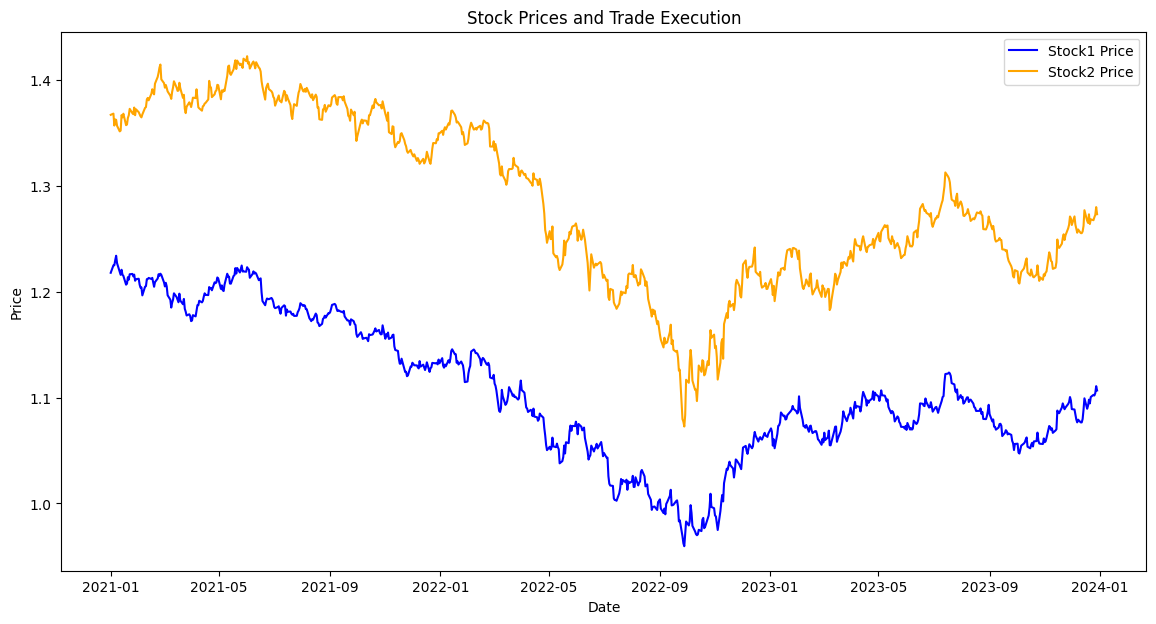

In [25]:

# Plot the prices of stock1 and stock2
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df.iloc[:, 0], label='Stock1 Price', color='blue')
plt.plot(merged_df.index, merged_df.iloc[:, 1], label='Stock2 Price', color='orange')

# Highlight trades
for i, row in trades_df.iterrows():
    if row['Trade'] == 'Buy Stock1/Sell Stock2':
        plt.scatter(row['Date'], merged_df.loc[row['Date'], merged_df.columns[0]], color='green', marker='^', s=100, label='Buy Stock1/Sell Stock2' if i == 0 else "")
        plt.scatter(row['Date'], merged_df.loc[row['Date'], merged_df.columns[1]], color='green', marker='v', s=100)
    elif row['Trade'] == 'Sell Stock1/Buy Stock2':
        plt.scatter(row['Date'], merged_df.loc[row['Date'], merged_df.columns[0]], color='red', marker='v', s=100, label='Sell Stock1/Buy Stock2' if i == 0 else "")
        plt.scatter(row['Date'], merged_df.loc[row['Date'], merged_df.columns[1]], color='red', marker='^', s=100)

plt.title('Stock Prices and Trade Execution')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Empty DataFrame
Columns: [Date, Pair, Trade_Type, Quantity_Stock1, Entry_Price_Stock1, Exit_Price_Stock1, Quantity_Stock2, Entry_Price_Stock2, Exit_Price_Stock2, Spread, Hedge_Ratio]
Index: []


In [23]:
import matplotlib.pyplot as plt

# Example function to plot data for a specific FX pair
def plot_fx_pair_trades(ticker):
    # Load historical data
    file_path = os.path.join('SAR5', f'{ticker}_adjusted_close_data.csv')
    historical_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    
    # Plot historical price data
    plt.figure(figsize=(14, 7))
    plt.plot(historical_data.index, historical_data['Adj Close'], label='Price', color='blue')
    
    # Filter trades for this specific ticker
    pair_trades = trades_df[trades_df['Pair'].str.contains(ticker)]
    
    # Plot entry points
    for _, trade in pair_trades.iterrows():
        if 'Long' in trade['Trade_Type']:
            plt.scatter(trade['Date'], trade['Entry_Price_Stock1'], color='green', marker='^', s=100, label='Long Entry')
        elif 'Short' in trade['Trade_Type']:
            plt.scatter(trade['Date'], trade['Entry_Price_Stock1'], color='red', marker='v', s=100, label='Short Entry')
    
    # Plot exit points
    for _, trade in pair_trades.iterrows():
        if 'Long' in trade['Trade_Type']:
            plt.scatter(trade['Date'], trade['Exit_Price_Stock1'], color='black', marker='v', s=100, label='Long Exit')
        elif 'Short' in trade['Trade_Type']:
            plt.scatter(trade['Date'], trade['Exit_Price_Stock1'], color='orange', marker='^', s=100, label='Short Exit')
    
    plt.title(f'Trades for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


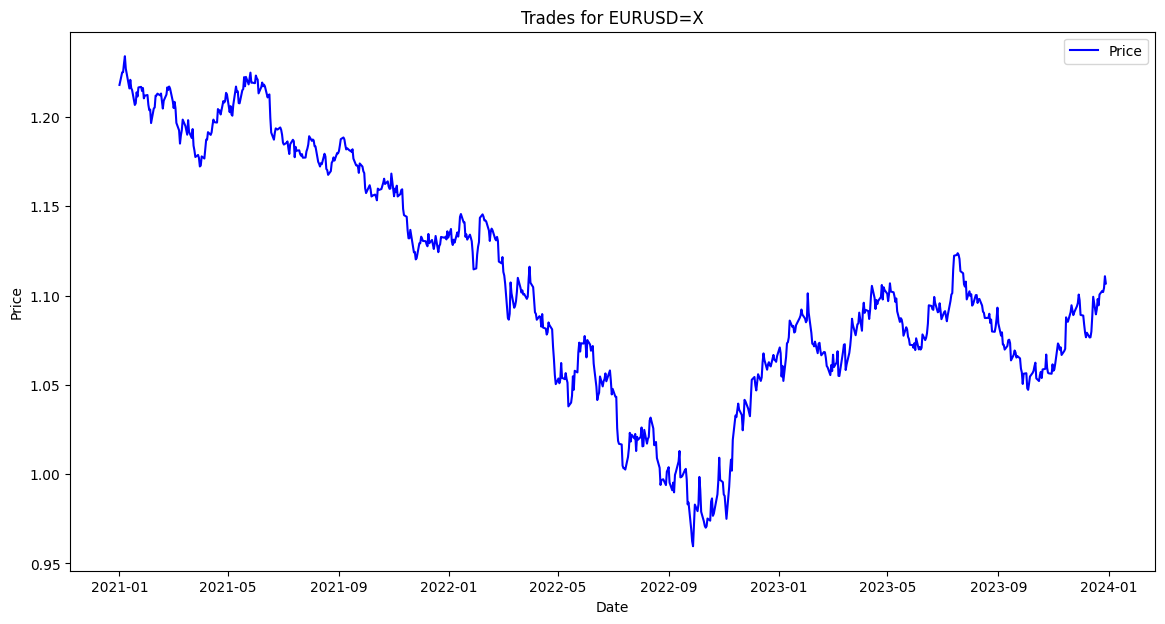

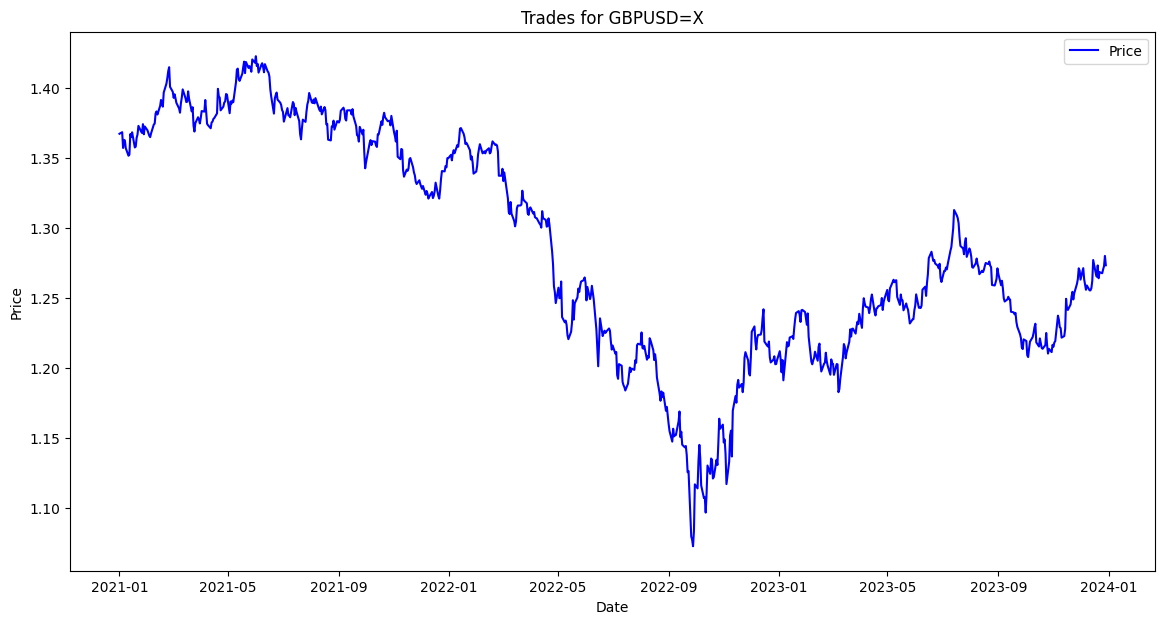

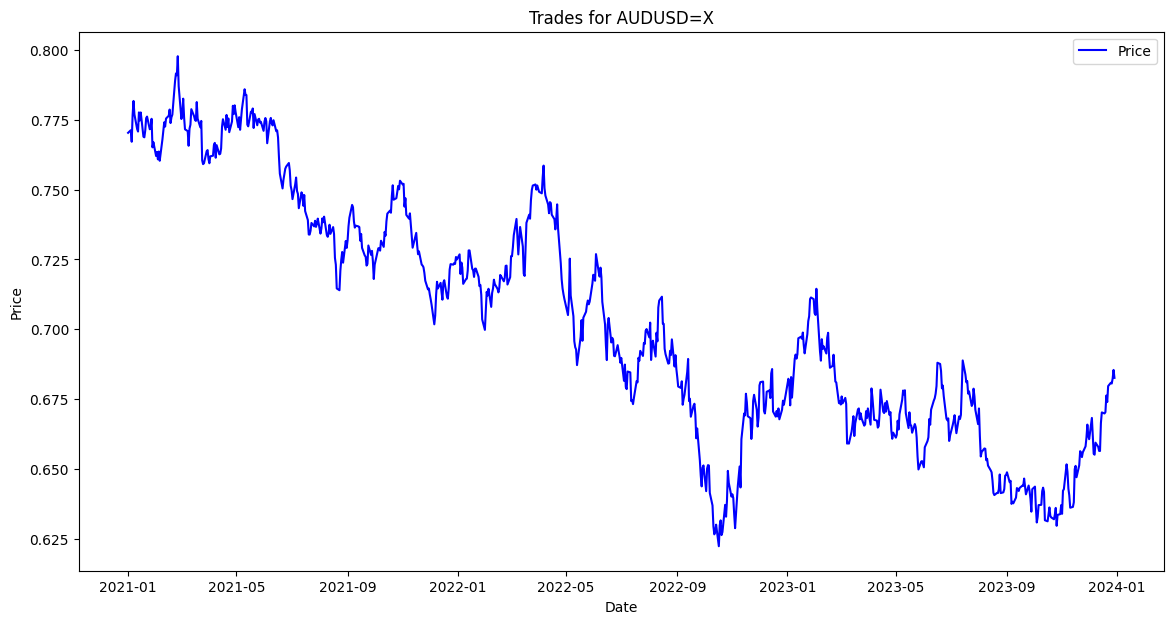

In [24]:
# Assuming 'tickers' is a list of your FX pairs
for ticker in tickers:
    plot_fx_pair_trades(ticker)
